In [2]:
#V první buňce načteme potřebné knihovny
import numpy as np
import matplotlib.pyplot as plt
from pysheds.grid import Grid
#from osgeo import gdal


In [3]:
#Načtěte digitální model terénu (DEM) pomocí knihovny GDAL
grid = Grid.from_raster('C:/Users/myska/OneDrive/Dokumenty/jup_kod/dem.tif')
dem = grid.read_raster('C:/Users/myska/OneDrive/Dokumenty/jup_kod/dem.tif')

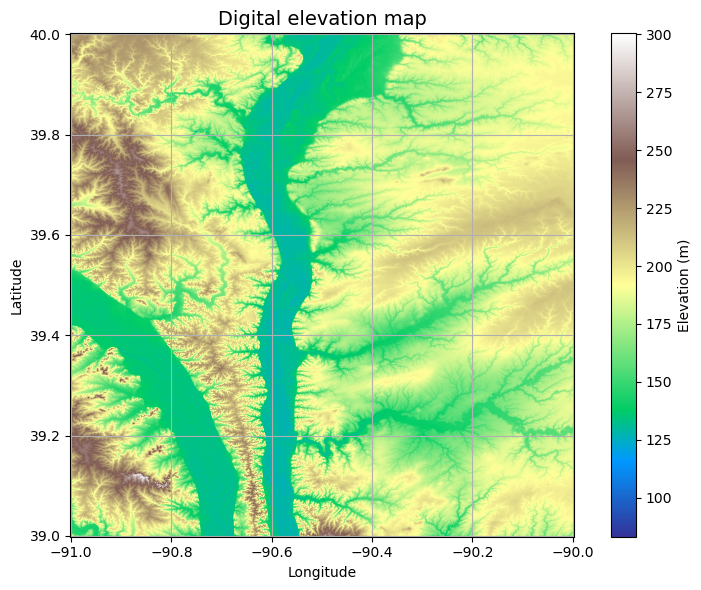

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [5]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [6]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

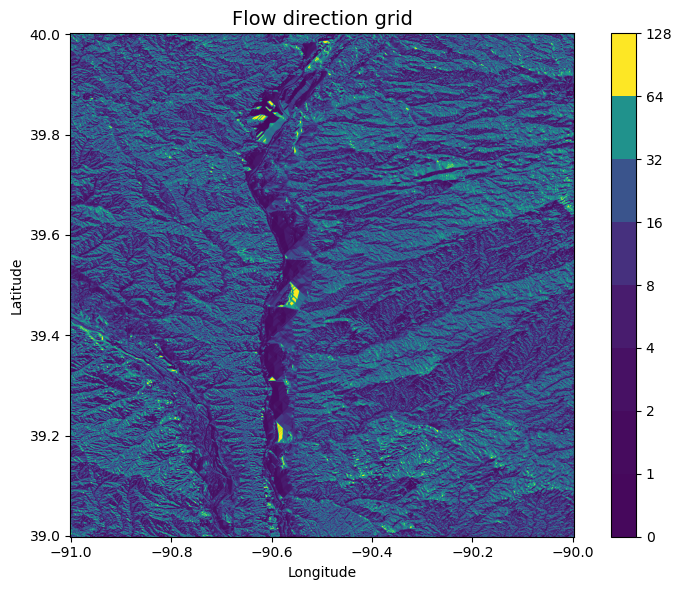

In [7]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [8]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

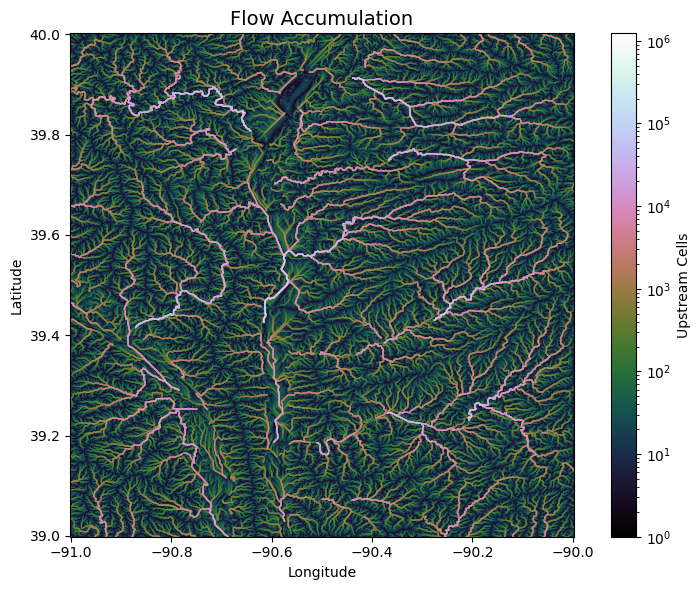

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [10]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = -97.294, 32.737

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

In [11]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

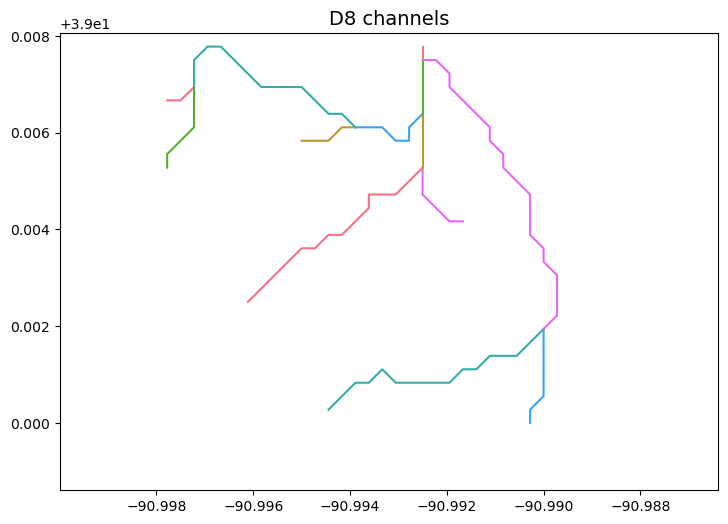

In [12]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [13]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

Text(0.5, 1.0, 'Flow Distance')

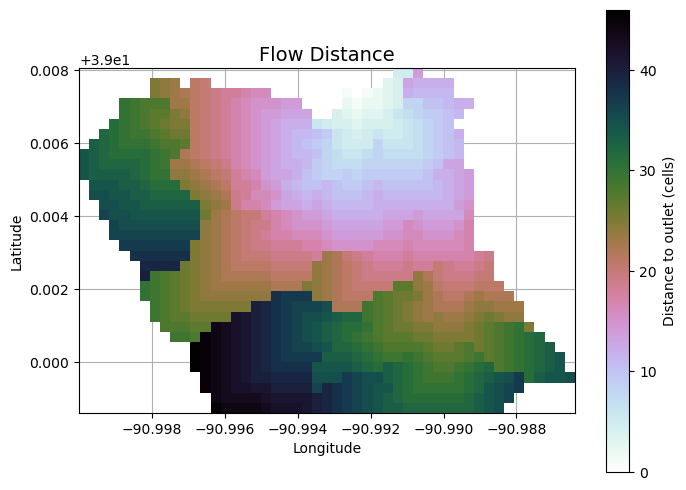

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)